In [3]:
#Importar paquetes
import pandas as pd
import numpy as np
import sqlite3 as sql
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interact

In [4]:
import os  ### para ver y cambiar directorio de trabajo

In [5]:
os.getcwd()

'c:\\Users\\anita\\OneDrive\\Documentos\\GitHub\\AnaliticaIII-Marketing'

In [6]:
###### para ejecutar sql y conectarse a bd ###

conn=sql.connect('db_movies')
cur=conn.cursor() ###para funciones que ejecutan sql en base de datos


In [7]:
def ejecutar_sql (nombre_archivo, cur):
    sql_file=open(nombre_archivo)
    sql_as_string=sql_file.read()
    sql_file.close
    cur.executescript(sql_as_string)

In [8]:
#######
############ cargar tablas ####

movies= pd.read_sql('select * from movies', conn)
ratings = pd.read_sql('select * from ratings', conn)

Tabla Movies

In [9]:
#Ver los primeros 5 datos de la tabla movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
#Observar columnas de movies
print('Columnas:',movies.columns)
#Dimensiones de la base
print('Dimensiones:', movies.shape)

Columnas: Index(['movieId', 'title', 'genres'], dtype='object')
Dimensiones: (9742, 3)


In [11]:
#Conocer el tipo de variables
print(movies.dtypes)

movieId     int64
title      object
genres     object
dtype: object


In [12]:
#Información general
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Tabla Ratings

In [13]:
#Ver primeros cinco datos de la tabla ratings
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [14]:
#Información general
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [15]:
#Observar columnas de movies
print('Columnas:',ratings.columns)
#Dimensiones de la base
print('Dimensiones:', ratings.shape)

Columnas: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Dimensiones: (100836, 4)


In [16]:
#Conocer el tipo de variables
print(ratings.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [17]:
#Ejemplo de cambio de formato de timestamp a datetime
from datetime import datetime
datetime.fromtimestamp(964982703)

datetime.datetime(2000, 7, 31, 4, 45, 3)

In [18]:
#Modificar formato de timestamp a datetime
from datetime import datetime
ratings['timestamp']= ratings.apply(lambda x: datetime.fromtimestamp(x['timestamp']), axis=1)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-31 04:45:03
1,1,3,4.0,2000-07-31 04:20:47
2,1,6,4.0,2000-07-31 04:37:04
3,1,47,5.0,2000-07-31 05:03:35
4,1,50,5.0,2000-07-31 04:48:51


Nueva base de datos

In [19]:
#Crear base de datos con la unión de las tablas de movies y ratings
movie_ratings = pd.merge(ratings,movies, how="left", right_on="movieId", left_on="movieId")
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-31 04:20:47,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-31 04:37:04,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-31 05:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-31 04:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [20]:
#Información general de la nueva base de datos
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.4+ MB


In [21]:
#Verificar si hay datos duplicados 
movie_ratings.duplicated().sum()

0

In [22]:
#Observar columnas de la nueva base de datos
movie_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [23]:
#Crear base de datos con variables dummies del campo genero 
genres = movies.copy()
genres = genres.drop(columns=['movieId', 'title'])
genres['genres'] = genres['genres'].str.split('|')
genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)
genres = pd.concat([genres, genres_dummies], axis=1).drop(columns=['genres'])
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
#Concatenar la base de datos movies con la base de datos de los generos de peliculas (dummies)
movies2 = pd.concat([movies, genres], axis=1)
movies2 = movies2.drop(['genres'], axis=1)
movies2.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#Base de datos con variables de movieid y title
movies3 = pd.melt(movies2, id_vars= ['movieId', 'title'])
print(movies3.columns)

Index(['movieId', 'title', 'variable', 'value'], dtype='object')


In [26]:
#Mostrar los primeros 10 datos de movies3
movies3.sample(10)

,movieId,title,variable,value
62794,6342,"Trip, The (2002)",Crime,0
59576,1466,Donnie Brasco (1997),Crime,1
60792,3098,"Natural, The (1984)",Crime,0
15776,39400,"Fog, The (2005)",Action,1
70111,2542,"Lock, Stock & Two Smoking Barrels (1998)",Documentary,0
24879,8998,That's Entertainment (1974),Adventure,0
139890,4786,"Legend of Hell House, The (1973)",Mystery,0
179092,5189,Humanoids from the Deep (1980),War,0
133232,55269,"Darjeeling Limited, The (2007)",Musical,0
24457,7614,Oklahoma! (1955),Adventure,0


In [27]:
#Tabla con el valor de cada genero
movies3.groupby('variable')[['value']].sum().reset_index()

,variable,value
0,(no genres listed),34.0
1,Action,1828.0
2,Adventure,1263.0
3,Animation,611.0
4,Children,664.0
5,Comedy,3756.0
6,Crime,1199.0
7,Documentary,440.0
8,Drama,4361.0
9,Fantasy,779.0


In [28]:
#Juntas bases de datos de movies con dummies y ratings 
movie_ratings1 = pd.merge(ratings,movies2, how="left", right_on="movieId", left_on="movieId")
movie_ratings1

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-31 04:20:47,Grumpier Old Men (1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-31 04:37:04,Heat (1995),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-31 05:03:35,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-31 04:48:51,"Usual Suspects, The (1995)",0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-04 07:53:22,Split (2017),0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,2017-05-04 08:21:31,John Wick: Chapter Two (2017),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,2017-05-09 05:50:47,Get Out (2017),0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,2017-05-04 07:19:12,Logan (2017),0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Anális Exploratorio

In [29]:
#Instalación de paquetes
pip install plotly
pip install nbformat

SyntaxError: invalid syntax (2034314683.py, line 2)

In [30]:
#Importar paquetes
import plotly.graph_objs as go #Graficos
import plotly.express as px
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt ### gráficos

In [31]:
# crear dataset
base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas más calificadas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)



(array([ 8791., 10332.,  8003.,  8822., 10673.,  8590., 11151., 12109.,
         6309., 16056.]),
 array([  1. ,  61.9, 122.8, 183.7, 244.6, 305.5, 366.4, 427.3, 488.2,
        549.1, 610. ]),
 <BarContainer object of 10 artists>)

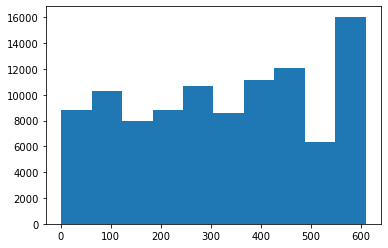

In [32]:
#Histograma
plt.hist(movie_ratings['userId'])

In [33]:
mr =  movie_ratings.groupby(['movieId','title','timestamp'])
mr

In [34]:
# ARREGLAR
# crear dataset
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b>Porcentaje de los 10 generos de películas más vistos <b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [35]:
#Crear dataset
final_dataset = movie_ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset = final_dataset.fillna(0)
final_dataset

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#saber cuantas calificaciones tiene cada pelicula
no_user_voted = movie_ratings.groupby('movieId')['rating'].agg('count')
#saber cuantas veces han calificado cada película
no_movies_voted = movie_ratings.groupby('userId')['rating'].agg('count')


In [37]:
#Maximo de votaciones de peliculas
print(no_movies_voted.max())
#Minimo de votaciones de peliculas
print(no_movies_voted.min())

2698
20


In [38]:
#Imprimir el numero de votos minimo por usuario
print(no_user_voted.min())
#Imprimir el numero de votos maximo por usuario
print(no_user_voted.max())

1
329


<AxesSubplot:title={'center':'Ratings por usuario'}, ylabel='Ratings'>

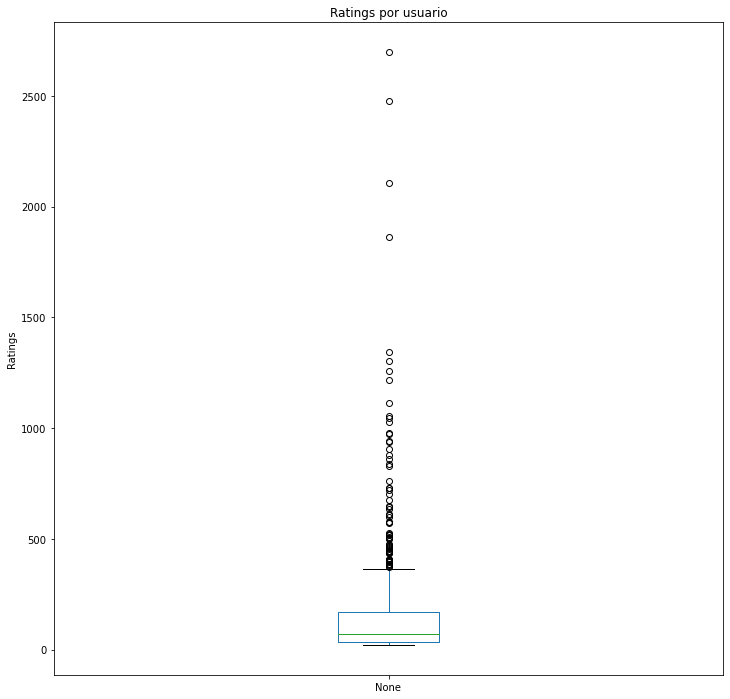

In [39]:
#Crear boxplot con ratings por usuarios
rated_movies_by_user = ratings.groupby("userId").size().sort_values(ascending=False)
rated_movies_by_user.plot.box(figsize=(12,12), ylabel="Ratings", title='Ratings por usuario')

In [40]:
#promedio de calificaciones por usuario
rated_movies_by_user = ratings.groupby("userId").size().count()
rated_movies_by_user

610

In [41]:
#Construir un dataset con los requisitos de votacion de los usuarios mayor a 10 y votacion de peliculas mayor a 100 
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 100].index]
final_dataset

userId,1,4,6,7,10,15,17,18,19,20,...,599,600,601,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,3.0,2.5,4.0,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,2.5,4.0,0.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.5,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [43]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [44]:
movie_name='Iron Man'

In [127]:
def get_movie_recommendation(Movie_id = list(movies['title'])):
    n_movies_to_reccomend = 10
    #movie_list = movies[movies['title'].str.contains(Movie_id)]  
    
    if len(Movie_id):
        Movie_id=movies[movies['title'].str.contains(Movie_id)]        
        movie_idx= Movie_id.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx =movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [128]:
get_movie_recommendation('Spider-Man')

,Title,Distance
1,Pirates of the Caribbean: The Curse of the Bla...,0.285845
2,Shrek (2001),0.282840
3,"Lord of the Rings: The Return of the King, The...",0.275932
4,"Bourne Identity, The (2002)",0.273384
5,X-Men (2000),0.271716
6,Star Wars: Episode II - Attack of the Clones (...,0.260246
7,Minority Report (2002),0.256223
8,"Lord of the Rings: The Two Towers, The (2002)",0.255674
9,"Lord of the Rings: The Fellowship of the Ring,...",0.243543
10,Spider-Man 2 (2004),0.232026


In [136]:
print(interact(get_movie_recommendation))

interactive(children=(Dropdown(description='Movie_id', options=('Toy Story (1995)', 'Jumanji (1995)', 'Grumpie…

<function get_movie_recommendation at 0x000002BDB7DA6310>


In [50]:
#Instalacion de paquetes
conda install -n notebook_env nb_conda_kernels
pip install -U ipykernel
conda install -c conda-forge scikit-surprise
pip install scikit-surprise

SyntaxError: invalid syntax (3637580900.py, line 2)

############################## Sistema de recomendación filtro colaborativo basado en usuario ##############################################

In [51]:
#Funciones del paquete surprise
from surprise import Reader, Dataset
#Escoger modeolos
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise.model_selection import train_test_split

In [52]:
# leer datos desde tabla de pandas
reader = Reader(rating_scale=(0, 10))

In [53]:
cell=final_dataset['movieId']
cell

0            1
1            2
2            3
3            5
4            6
         ...  
2116    174055
2117    176371
2118    177765
2119    179819
2120    187593
Name: movieId, Length: 2121, dtype: int64

In [54]:
cell=pd.DataFrame(cell)
cell

,movieId
0,1
1,2
2,3
3,5
4,6
...,...
2116,174055
2117,176371
2118,177765
2119,179819


In [55]:
ratingssel = pd.merge(cell,movie_ratings, how="left", right_on="movieId", left_on="movieId")
ratingssel

,movieId,userId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,5,4.0,1996-11-08 17:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,7,4.5,2005-01-25 17:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,15,2.5,2017-11-13 23:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,17,4.5,2011-05-18 15:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
79631,187593,331,4.0,2018-09-18 11:49:54,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79632,187593,338,1.0,2018-06-28 11:14:25,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79633,187593,380,3.0,2018-07-12 09:19:53,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79634,187593,514,3.5,2018-09-17 12:18:46,Deadpool 2 (2018),Action|Comedy|Sci-Fi


In [56]:
#Descargar base de datos
data   = Dataset.load_from_df(ratingssel[['userId','movieId','rating']], reader)

In [57]:
#Funcion para el uso de todos los modelos y analizar cual se comporta mejor
models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()] 
results = {}

for model in models:
 
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result



In [58]:
#Comportamiento de los modelos
performance_df = pd.DataFrame.from_dict(results).T
performance_df.sort_values(by='RMSE')
#El mejor es el KNNBaseline tiene el menor MAE y RMSE

,MAE,RMSE,fit_time,test_time
knns.KNNBaseline,0.642070,0.840001,0.377527,3.939315
knns.KNNWithZScore,0.648299,0.852205,0.264455,2.053131
knns.KNNWithMeans,0.652881,0.853060,0.237761,1.860031
knns.KNNBasic,0.693733,0.903391,0.227205,1.686377


In [59]:
#Se implemento el MSD y cosenos
#Minimo de neighbours para la prediccion
param_grid = { 'sim_options' : {'name': ['msd','cosine'], \
                                'min_support': [5], \
                                'user_based': [False, True]}
             }

In [60]:
#Funcion con GridSearchCV
gridsearchKNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], \
                                      cv=2, n_jobs=2)
gridsearchKNNBaseline.fit(data)

Sistema de recomendación basado en filtro colaborativo de usuario
Metodo de correlación de Pearson 

In [65]:
#Base de datos con movieId, title y ratings
InpMov = ratingssel[['movieId','title','rating']]
InpMov

,movieId,title,rating
0,1,Toy Story (1995),4.0
1,1,Toy Story (1995),4.0
2,1,Toy Story (1995),4.5
3,1,Toy Story (1995),2.5
4,1,Toy Story (1995),4.5
...,...,...,...
79631,187593,Deadpool 2 (2018),4.0
79632,187593,Deadpool 2 (2018),1.0
79633,187593,Deadpool 2 (2018),3.0
79634,187593,Deadpool 2 (2018),3.5


In [66]:
#Base de datos de ratings sin timestamp
newrate = ratings.drop('timestamp',1)
newrate

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [67]:
#Filtrado de usuarios que han visto las peliculas 
visto = newrate[newrate['movieId'].isin(InpMov['movieId'].tolist())]
visto.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [68]:
#Se crean diferentes dataframes donde usan el mismo vamor para el campo especificado
vistogroup = visto.groupby('userId')
vistogroup.get_group(300)

,userId,movieId,rating
45497,300,318,4.0
45498,300,356,4.0
45499,300,527,5.0
45500,300,593,4.0
45501,300,1172,5.0
45502,300,1704,3.0
45503,300,2028,4.0
45504,300,2324,5.0
45505,300,2329,4.0
45506,300,2571,4.0


In [69]:
#Se ordena para que los usuarios que hayan visto mas peliculas tengan prioridad 
vistogroup = sorted(vistogroup,  key=lambda x: len(x[1]), reverse=True)
#Observar un usuario
vistogroup[0:3]

[(414,
         userId  movieId  rating
  62294     414        1     4.0
  62295     414        2     3.0
  62296     414        3     4.0
  62297     414        5     2.0
  62298     414        6     3.0
  ...       ...      ...     ...
  64960     414   166528     4.0
  64965     414   168252     4.0
  64975     414   174055     5.0
  64978     414   176371     5.0
  64985     414   179819     4.5
  
  [1569 rows x 3 columns]),
 (599,
         userId  movieId  rating
  92623     599        1     3.0
  92624     599        2     2.5
  92625     599        3     1.5
  92626     599        6     4.5
  92627     599        7     2.5
  ...       ...      ...     ...
  95063     599   166528     3.0
  95066     599   168250     3.0
  95067     599   168252     3.5
  95087     599   174055     4.0
  95090     599   176371     3.5
  
  [1327 rows x 3 columns]),
 (68,
         userId  movieId  rating
  10360      68        1     2.5
  10361      68        2     2.5
  10362      68        3   

In [70]:
#Se elije un conjunto de usuarios 
vistogroup = vistogroup[0:100]

In [71]:
from math import sqrt

#La correlación de Pearson = diccionario 
PearsonCorrelation = {}
for name, group in vistogroup:
    group = group.sort_values(by='movieId')
    InpMov = InpMov.sort_values(by='movieId')
#Sacar N
    n = len(group)
#Obtener puntajes de revisión
    temp = InpMov[InpMov['movieId'].isin(group['movieId'].tolist())]
    tempRate = temp['rating'].tolist()
    tempGroup = group['rating'].tolist()
  #Calcular la Correlación Pearson entre dos usuarios, x e y
    Sxx = sum([i**2 for i in tempRate]) - pow(sum(tempRate),2)/float(n)
    Syy = sum([i**2 for i in tempGroup]) - pow(sum(tempGroup),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRate, tempGroup)) - sum(tempRate)*sum(tempGroup)/float(n)
    if Sxx != 0 and Syy != 0:
        PearsonCorrelation[name] = abs(Sxy/(sqrt(abs(Sxx*Syy))))
    else:
        PearsonCorrelation[name] = 0
PearsonCorrelation.items()

dict_items([(414, 3.874894469215089), (599, 3.5770177982189026), (68, 3.575947927067881), (474, 3.9093751132682066), (448, 3.4027065377684353), (274, 4.6077456504348335), (380, 4.039989968368456), (288, 3.874641801714459), (249, 6.19027254828402), (610, 4.620910547091089), (608, 3.0468199353577177), (182, 3.402181593888422), (177, 3.522161872963864), (480, 3.3235915793110684), (298, 2.5987535941814373), (590, 4.037557130884593), (387, 3.8481240836365176), (307, 2.8801582080057), (606, 4.690676008209393), (600, 2.7746282034540055), (483, 3.7394278734420423), (489, 2.5800893248922145), (232, 4.849581059411035), (603, 2.8608120164592608), (305, 4.310120725500069), (19, 2.8285685986330753), (318, 7.080160695720281), (477, 4.108952068300912), (438, 4.160118951081695), (64, 5.030707575186172), (219, 3.0613743409907443), (561, 4.069161772152634), (105, 6.9600359848948266), (91, 3.5845606989583114), (217, 3.1879919844504596), (525, 4.7602234127766865), (226, 4.193559494122212), (381, 4.3323685

In [72]:
#Calcular la correlación Pearson 
pearsonDF = pd.DataFrame.from_dict(PearsonCorrelation, orient='index')
pearsonDF.columns = ['Index Similar']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,Index Similar,userId
0,3.874894,414
1,3.577018,599
2,3.575948,68
3,3.909375,474
4,3.402707,448


In [73]:
topUsers=pearsonDF.sort_values(by='Index Similar', ascending=False)[0:50]
topUsers.head()

,Index Similar,userId
81,9.826836,122
94,7.167925,169
26,7.080161,318
32,6.960036,105
71,6.529691,425


In [75]:
topUsersRating=topUsers.merge(newrate, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,Index Similar,userId,movieId,rating
0,9.826836,122,2,4.0
1,9.826836,122,19,3.5
2,9.826836,122,32,5.0
3,9.826836,122,47,4.5
4,9.826836,122,50,5.0


In [76]:
#Se multiplica la similitud de los puntajes de los usuarios
topUsersRating['Rating Peso'] = topUsersRating['Index Similar']*topUsersRating['rating']
topUsersRating.head()

,Index Similar,userId,movieId,rating,Rating Peso
0,9.826836,122,2,4.0,39.307343
1,9.826836,122,19,3.5,34.393925
2,9.826836,122,32,5.0,49.134178
3,9.826836,122,47,4.5,44.220760
4,9.826836,122,50,5.0,49.134178


In [77]:
#Se aplica una suma a los topUsers luego de agruparlos por userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['Index Similar','Rating Peso']]
tempTopUsersRating.columns = ['Suma Index Similar','Suma Rating Peso']
tempTopUsersRating.head()


,Suma Index Similar,Suma Rating Peso
movieId,,
1,188.333446,751.031457
2,141.877758,521.604976
3,30.074043,114.705454
4,4.919793,14.759378
5,45.742438,156.826623


In [78]:
recommendation_df = pd.DataFrame()
#Ahora se toma el promedio ponderado
recommendation_df['Peso promedio de recomendación'] = tempTopUsersRating['Suma Rating Peso']/tempTopUsersRating['Suma Index Similar']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()


,Peso promedio de recomendación,movieId
movieId,,
1,3.987775,1
2,3.676439,2
3,3.814102,3
4,3.000000,4
5,3.428471,5


In [79]:
recommendation_df = recommendation_df.sort_values(by='Peso promedio de recomendación', ascending=False)
recommendation_df.head(10)

,Peso promedio de recomendación,movieId
movieId,,
140265,5.0,140265
109633,5.0,109633
134095,5.0,134095
120138,5.0,120138
7080,5.0,7080
147328,5.0,147328
172637,5.0,172637
172793,5.0,172793
147330,5.0,147330


In [80]:
movies.loc[movies['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,genres
4755,7080,42nd Street (1933),Drama|Musical|Romance
8381,109633,"Garden of Words, The (Koto no ha no niwa) (2013)",Animation|Romance
8646,120138,PK (2014),Comedy|Drama|Fantasy|Mystery|Romance
8877,134095,My Love (2006),Animation|Drama
9012,140265,George Carlin: Jammin' in New York (1992),Comedy
9143,147328,The Adventures of Sherlock Holmes and Dr. Wats...,Crime
9144,147330,Sherlock Holmes and Dr. Watson: Acquaintance (...,Crime
9542,172637,Priklyucheniya Kapitana Vrungelya (1979),Action|Adventure|Animation|Comedy
9544,172793,Vovka in the Kingdom of Far Far Away (1965),Adventure|Animation|Children|Fantasy
9633,179133,Loving Vincent (2017),Animation|Crime|Drama


Sistema de recomendación basado en contenido

Con base en todo lo visto por el usuario

In [147]:
movies2.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
generos = movie_ratings1.drop('movieId',1).drop('title',1).drop('(no genres listed)',1).drop('userId',1).drop('rating',1).drop('timestamp',1)
generos

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
100832,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
100833,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
100834,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [159]:
movie_ratings1['rating']

0         4.0
1         4.0
2         4.0
3         5.0
4         5.0
         ... 
100831    4.0
100832    5.0
100833    5.0
100834    5.0
100835    3.0
Name: rating, Length: 100836, dtype: float64

In [164]:
#Se usara el producto escalar para obtener los valores 
usuario = generos.transpose().dot(movie_ratings1['rating'])
usuario

Action         105629.0
Adventure       84771.5
Animation       25366.0
Children        31426.5
Comedy         132183.5
Crime           61024.0
Documentary      4629.5
Drama          153296.5
Fantasy         41312.5
Film-Noir        3410.5
Horror          23755.5
IMAX            14998.0
Musical         14746.5
Mystery         27875.5
Romance         63552.0
Sci-Fi          59587.0
Thriller        92415.5
War             18504.5
Western          6917.0
dtype: float64

In [175]:
#Géneros de cada película al marco de datos original
tablaGeneros = movie_ratings1.set_index(movie_ratings1['movieId'])
#Se eliminan algunas columnas
tablaGeneros = tablaGeneros.drop('movieId', 1).drop('title', 1).drop('(no genres listed)', 1).drop('userId', 1).drop('rating', 1).drop('timestamp', 1)
tablaGeneros.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
47,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
50,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [176]:
TablaRecomendaciones = ((generos*usuario).sum(axis=1))/(usuario.sum())
TablaRecomendaciones.head()


0    0.326351
1    0.202750
2    0.268353
3    0.124602
4    0.187813
dtype: float64

In [177]:
#Ordena nuestra recomendación en orden descendente
TablaRecomendaciones = TablaRecomendaciones.sort_values(ascending=False)
#Valores
TablaRecomendaciones.head()


100469    0.716053
29899     0.716053
34103     0.656169
25315     0.656169
67923     0.656169
dtype: float64

In [187]:
#Tabla de recomendaciones final
movies.loc[movies['movieId'].isin(TablaRecomendaciones.head(100).keys())]

,movieId,title,genres
527,616,"Aristocats, The (1970)",Animation|Children
1323,1785,King of New York (1990),Crime|Thriller
3431,4675,Three Fugitives (1989),Action|Comedy
6771,60046,"Children of Huang Shi, The (2008)",Drama|War
6974,66371,Departures (Okuribito) (2008),Drama
7006,67923,"Fast & Furious (Fast and the Furious 4, The) (...",Action|Crime|Drama|Thriller
7816,92637,Pitfall (Otoshiana) (1962),Crime|Drama|Fantasy
7861,93980,"Three Stooges, The (2012)",Comedy
